# Hello :)

Code developed by:

Carmel Natasha Barnabas

Allysa Amani binti Kamardin

Code has been adapted from DeepCharts on GitHub (https://github.com/deepcharts/projects/blob/main/Technical_Indicators_For_Machine_Learning.ipynb)

Note:

If you run into issues with pandas_ta:

Install it

!pip install -U git+https://github.com/twopirllc/pandas-ta

Restart the runtime

In [ ]:
# ! pip install -U git+https://github.com/twopirllc/pandas-ta

In [1]:
# Note 06/05: pandas-ta officially migrated, so set up is now different:
!pip install pandas-ta
!pip install numpy==1.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=a6d9f893cbfd0e3c34fb70c36fce26ad8dd88951dec7696157366692009ea2d8
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
trees

In [1]:
# Note 06/05: yfinance has an issue with rate limits, if you encounter this issue, uncomment and run this code:
!pip uninstall yfinance
!pip install git+https://github.com/bretsky/yfinance.git@fix/curl-cffi-cookies

Found existing installation: yfinance 0.2.57
Uninstalling yfinance-0.2.57:
  Would remove:
    /usr/local/bin/sample
    /usr/local/lib/python3.11/dist-packages/yfinance-0.2.57.dist-info/*
    /usr/local/lib/python3.11/dist-packages/yfinance/*
Proceed (Y/n)? Y
  Successfully uninstalled yfinance-0.2.57
  Cloning https://github.com/bretsky/yfinance.git (to revision fix/curl-cffi-cookies) to /tmp/pip-req-build-utqxv1vt
  Running command git clone --filter=blob:none --quiet https://github.com/bretsky/yfinance.git /tmp/pip-req-build-utqxv1vt
  Running command git checkout -b fix/curl-cffi-cookies --track origin/fix/curl-cffi-cookies
  Switched to a new branch 'fix/curl-cffi-cookies'
  Branch 'fix/curl-cffi-cookies' set up to track remote branch 'fix/curl-cffi-cookies' from 'origin'.
  Resolved https://github.com/bretsky/yfinance.git to commit ad33ab9b77d1ef534ed35cba03598a1b317cfdd3
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 71.7 MB/s et

In [3]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data Preparation
1. Getting the Data
2. Shifting columns; 1-day trading lag shift
3. Adding technical indicators
4. Dropping NaNs in rows


In [4]:
# getting the data

full_df = yf.download('^SPX', start="2004-01-01", end="2024-12-31")
full_df = full_df[['Open', 'High', 'Low', 'Close', 'Volume']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
def add_shifted_columns(df_temp):
    df_temp['Previous_Close'] = df_temp['Close'].shift(1) # Prev Day Close Feature
    df_temp['Close_Shifted'] = df_temp['Close'].shift(1) # Prev Day Close Feature
    df_temp['Open_Shifted'] = df_temp['Open'].shift(1)
    df_temp['High_Shifted'] = df_temp['High'].shift(1)
    df_temp['Low_Shifted'] = df_temp['Low'].shift(1)
    return df_temp

def add_indicators(df_temp):
    df_temp = add_shifted_columns(df_temp)
    # Simple Moving Average (SMA): Avg price over last 50 periods
    df_temp['SMA_50'] = ta.sma(df_temp['Close_Shifted'], length=50)

    # Exponential Moving Average (EMA): Weighted average that reacts faster to recent price changes, using 50 periods
    df_temp['EMA_50'] = ta.ema(df_temp['Close_Shifted'], length=50)

    # Relative Strength Index (RSI) : Momentum Indicator that measures the magnitude of recent price changes to evaluate overbought/sold conditions
    df_temp['RSI'] = ta.rsi(df_temp['Close_Shifted'], length=14)

    # Moving Average Convergence Divergence (MACD) : Trend-following momentum indicator: using 12 and 26 periods for fast and slow EMAs and 9-period signal
    macd = ta.macd(df_temp['Close_Shifted'], fast = 12, slow = 26, signal = 9)
    df_temp['MACD'] = macd['MACD_12_26_9']
    df_temp['Signal_Line'] = macd['MACDs_12_26_9']

    # Bollinger Bands: Volatility indicator using a 20-period moving average and 2 standard deviations
    bollinger = ta.bbands(df_temp['Close_Shifted'], length=20, std=2)
    df_temp['Upper_Band'] = bollinger['BBU_20_2.0']
    df_temp['Middle_Band'] = bollinger['BBU_20_2.0']
    df_temp['Lower_Band'] = bollinger['BBL_20_2.0']

    # Stochastic Oscillator: Momentum indicator comparing closing pricess to price ranges over 14 periods with a 3-period %D moving average
    stoch = ta.stoch(df_temp['High_Shifted'], df_temp['Low_Shifted'], df_temp['Close_Shifted'], k=14, d=3)
    df_temp['Stoch_K'] = stoch['STOCHk_14_3_3']
    df_temp['Stoch_D'] = stoch['STOCHd_14_3_3']

    # Average True Range (ATR): Measures volatility by averaging true ranges over 14 periods
    df_temp['ATR'] = ta.atr(df_temp['High_Shifted'], df_temp['Low_Shifted'], df_temp['Close_Shifted'], length=14)

    return df_temp.dropna()

# Apply to all sets
full_df= add_indicators(full_df)
full_df = full_df.dropna()

# splitting dataset
df = full_df[full_df.index < "2015-01-01"]
df_val = full_df[(full_df.index >= "2015-01-01") & (full_df.index < "2021-01-01")]
df_test = full_df[full_df.index >= "2021-01-01"]

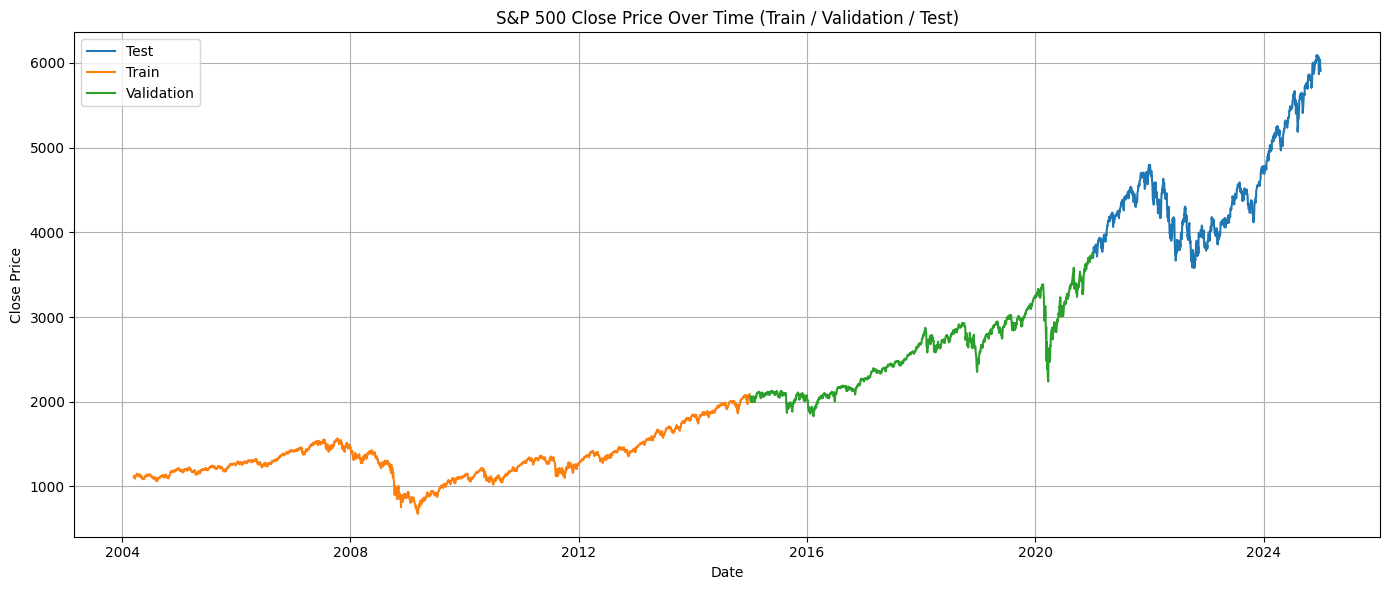

In [6]:
import matplotlib.pyplot as plt

def plot_actual_close_prices(df_train, df_val, df_test):
    # Combine the three datasets
    df_train = df_train.copy()
    df_val = df_val.copy()
    df_test = df_test.copy()

    df_train['Set'] = 'Train'
    df_val['Set'] = 'Validation'
    df_test['Set'] = 'Test'

    full_df = pd.concat([df_train, df_val, df_test])

    # Plot
    plt.figure(figsize=(14, 6))
    for label, group in full_df.groupby('Set'):
        plt.plot(group.index, group['Close'], label=label)

    plt.title("S&P 500 Close Price Over Time (Train / Validation / Test)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_close_prices(df, df_val, df_test)

# Preparing for Modelling

In [7]:
# parameters
window_size = 20 # 4 weeks of trading days (5 weekdays per week * 4 weeks = 20)

# inclusive of indicators as well as the previous day's closing price
# this provides insight as to the impact of the technical indicators has on the price
indicators = ['SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Close_Shifted', 'Previous_Close']

# initializing a dictionary to store predictions, actual and daily MAE
results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []} for indicator in indicators}

# Flatten MultiIndex column headers, keeping only the first level (e.g., 'SMA_50')

def flatten_column(df):
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

print(f"Train data length: {len(df)}")
print(f"Validation data length: {len(df_val)}")
print(f"Test data length: {len(df_test)}")

flatten_column(df)
flatten_column(df_val)
flatten_column(df_test)

print(df.columns.tolist())
print(df_val.columns.tolist())
print(df_test.columns.tolist())


Train data length: 2719
Validation data length: 1511
Test data length: 1004
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR']
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR']
['Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR']


# The Model

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# predicting the actual close price by a rolling 4 weeks windows, set by window_size

# The model is trained from scratch every day using only the previous 4 weeks of data.
# Each prediction is for the next unseen day, so it's a form of out-of-sample testing.
# This simulates a realistic trading/investment scenario, where you always train on past data and predict the future.
# Ideal for time-series forecasting.

print(f"Train data length: {len(df)}")
print(f"Validation data length: {len(df_val)}")
print(f"Test data length: {len(df_test)}")


def normalize_features(train_df, val_df, test_df, features):
    scaler = MinMaxScaler()
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()

    # Fit only on training data
    scaler.fit(train_df[features])

    # Transform all sets
    train_scaled[features] = scaler.transform(train_df[features])
    val_scaled[features] = scaler.transform(val_df[features])
    test_scaled[features] = scaler.transform(test_df[features])

    return train_scaled, val_scaled, test_scaled


def rolling_prediction(df_segment, window_size, indicators):
    results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': [], 'train_mae': []}
           for indicator in indicators if indicator != 'Previous_Close'}

    for indicator in indicators:
    #for indicator in indicators[:-1]:
        for i in range(window_size, len(df_segment) - 1):
            train_df = df_segment.iloc[i - window_size:i]
            test_index = i + 1

            if test_index >= len(df_segment):
                break

            X_train = train_df[[indicator, 'Previous_Close']]
            y_train = train_df['Close']

            X_train = sm.add_constant(X_train, has_constant='add')


            #model = sm.OLS(y_train, X_train).fit()

            # Train Random Forest model
            model = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=5)
            model.fit(X_train, y_train)

            print("X_train column:", X_train.columns)

            train_mae = mean_absolute_error(y_train, model.predict(X_train))
            results[indicator]['train_mae'].append(train_mae)

            X_test = df_segment[[indicator, 'Previous_Close']].iloc[[test_index]]
            X_test = sm.add_constant(X_test, has_constant='add')
            prediction = model.predict(X_test)[0]


            print("X_test column:", X_test.columns)
            actual = df_segment['Close'].iloc[test_index]

            results[indicator]['predictions'].append(prediction)
            results[indicator]['actual'].append(actual)
            results[indicator]['daily_mae'].append(abs(actual - prediction))

    return results

Train data length: 2719
Validation data length: 1511
Test data length: 1004


In [8]:
# Normalize features
df_norm, df_val_norm, df_test_norm = normalize_features(df, df_val, df_test, indicators)

train_results = rolling_prediction(df_norm, window_size=20, indicators=indicators)
val_results = rolling_prediction(df_val_norm, window_size=20, indicators=indicators)
test_results = rolling_prediction(df_test_norm, window_size=20, indicators=indicators)

# Check the final results after running the function
print("Train Results:", train_results)
print("Val Results:", val_results)
print("Test Results:", test_results)

Streaming output truncated to the last 5000 lines.
X_test column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Stoch_D', 'Previous_Close'], dtype='object')
X_test column: Inde

In [9]:
# This section is for seeing the output in for just stock predictiton without sentiment analysis.
# Uncomment the code if you wish to see this.
# Test Results

import numpy as np

print("Train Results")
print("Indicator\tTrain MAE\tTest MAE")
for indicator in indicators[:-1]:
    avg_train_mae = np.mean(train_results[indicator]['train_mae'])
    avg_test_mae = np.mean(train_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_test_mae:.4f}")

print("\n" + "="*50 + "\n")

# Validation Results
print("Validation Results")
print("Indicator\tTrain MAE\tVal MAE")
for indicator in indicators[:-1]:  # Exclude 'Previous_Close'-only case
    avg_train_mae = np.mean(val_results[indicator]['train_mae'])
    avg_val_mae = np.mean(val_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_val_mae:.4f}")

print("\n" + "="*50 + "\n")

# Test Results
print("Test Results")
print("Indicator\tTrain MAE\tTest MAE")
for indicator in indicators[:-1]:
    avg_train_mae = np.mean(test_results[indicator]['train_mae'])
    avg_test_mae = np.mean(test_results[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_test_mae:.4f}")

Train Results
Indicator	Train MAE	Test MAE
SMA_50         	6.0823		14.9886
EMA_50         	6.1930		14.8502
RSI            	6.8811		14.3497
MACD           	6.5742		14.7948
Signal_Line    	6.2876		14.8903
Upper_Band     	6.3955		15.2265
Middle_Band    	6.3955		15.2265
Lower_Band     	6.3855		15.0870
Stoch_K        	6.6998		14.8622
Stoch_D        	6.6105		15.1746
ATR            	6.6497		14.7567
Close_Shifted  	7.2675		14.0249


Validation Results
Indicator	Train MAE	Val MAE
SMA_50         	11.0870		27.2052
EMA_50         	11.2174		27.3010
RSI            	12.2484		26.7873
MACD           	11.9532		27.3523
Signal_Line    	11.3230		27.8979
Upper_Band     	11.6477		28.0849
Middle_Band    	11.6477		28.0849
Lower_Band     	11.4006		28.0362
Stoch_K        	12.0302		27.8064
Stoch_D        	11.8236		28.3563
ATR            	11.5895		27.4787
Close_Shifted  	13.1096		25.9935


Test Results
Indicator	Train MAE	Test MAE
SMA_50         	20.1419		51.9832
EMA_50         	20.6957		52.3049
RSI            	22

In [9]:
import pickle

# Load the pickled file
with open('train_results.pkl', 'rb') as f:
    train_results = pickle.load(f)

with open('val_results.pkl', 'rb') as f:
    val_results = pickle.load(f)

with open('test_results.pkl', 'rb') as f:
    test_results = pickle.load(f)


Top 3 indicators by validation MAE: ['Close_Shifted', 'RSI', 'SMA_50']


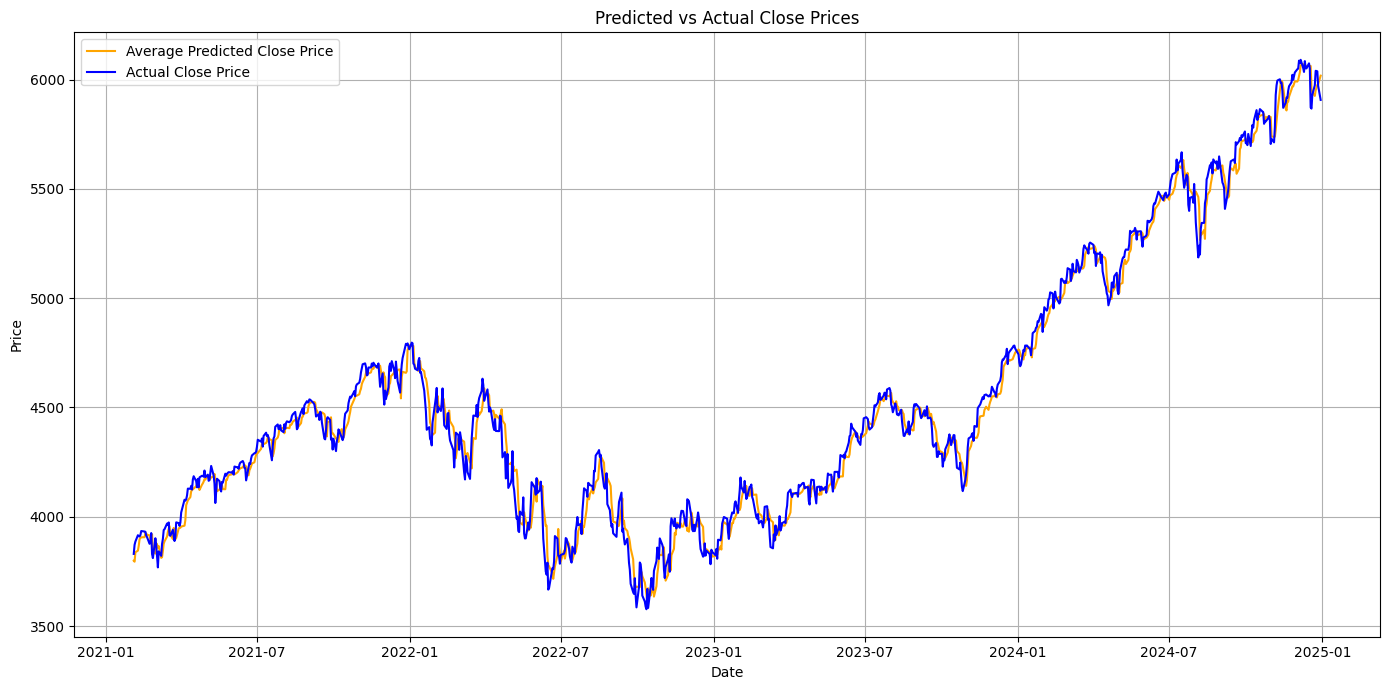

In [10]:
# seeing results for stock prediction without sentiment analysis
import matplotlib.pyplot as plt
import numpy as np

# Compute average prediction across all indicators (excluding 'Previous_Close')
avg_preds = []
actual_prices = []

# find the top 3 indicators with the lowest validation MAE
mae_scores = {}

for ind in indicators[:-1]:  # Exclude 'Previous_Close'
    preds = test_results[ind]['predictions']
    actuals = test_results[ind]['actual']
    mae = mean_absolute_error(actuals, preds)
    mae_scores[ind] = mae

# sort indicators by MAE and pick the best 3
top_3_indicators = sorted(mae_scores, key=mae_scores.get)[:3]

print("Top 3 indicators by validation MAE:", top_3_indicators)

# find average of only the top 3 indicators
num_preds = len(test_results[top_3_indicators[0]]['predictions'])  # They all have the same number

for i in range(num_preds):
    preds = [test_results[ind]['predictions'][i] for ind in top_3_indicators]
    avg_preds.append(np.mean(preds))  # Average of top 3 predictions
    actual_prices.append(test_results[top_3_indicators[0]]['actual'][i])  # Same actual for all

test_dates = df_test.index[window_size + 1: window_size + 1 + num_preds]

# plot
plt.figure(figsize=(14, 7))
plt.plot(test_dates, avg_preds, label='Average Predicted Close Price', color='orange')
plt.plot(test_dates, actual_prices, label='Actual Close Price', color='blue')
plt.title("Predicted vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import pickle

# Save stacked_results to a file
with open('/content/train_results.pkl', 'wb') as f:
    pickle.dump(train_results, f)

with open('/content/val_results.pkl', 'wb') as f:
    pickle.dump(val_results, f)

with open('/content/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

from google.colab import files

# Download saved results to your local machine
files.download('/content/train_results.pkl')
files.download('/content/val_results.pkl')
files.download('/content/test_results.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Stock Sentiment Analysis

In [27]:
!pip install transformers

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.11/dist-packages/transformers-4.51.3.dist-info/*
    /usr/local/lib/python3.11/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 104.5 MB/s eta 0:00:00


In [11]:
from transformers import pipeline
import pandas as pd

pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Load both CSV files
csv_file1 = "/content/sp500_news_290k_articles.csv"  # original
csv_file2 = "/content/stock_data_articles.csv"  # the new one

df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)

# Standardize df2 to match df1 format
df2 = df2.rename(columns={
    'symbol': 'ticker',
    'Publishdate': 'date',
    'Title': 'headline'
})
df2['time'] = None  # no time info available in new news
df2 = df2[['ticker', 'date', 'headline', 'time']]  # keep only these columns

# Combine the two dataframes
df_news = pd.concat([df1[['ticker', 'date', 'headline', 'time']], df2], ignore_index=True)

# Your keyword list
keyword_list = ['Apple', 'Microsoft', 'Nvidia', 'Amazon', 'Meta', 'Berkshire', 'Google', 'Alphabet Inc.', 'Broadcom Inc.', 'Tesla', 'GSPC', 'SPY', 'SPX']

sentiment_scores = []
total_score = 0
num_articles = 0

for idx, row in df_news.iterrows():
    headline = str(row['headline'])  # Just in case of missing data
    ticker = str(row['ticker'])

    # Check if any keyword matches in the headline
    if not any(keyword.lower() in headline.lower() for keyword in keyword_list):
        continue

    print(f'Ticker: {ticker}')
    print(f'Headline: {headline}')
    print(f'Date: {row["date"]} {row["time"]}')

    # Run sentiment analysis
    sentiment = pipe(headline)[0]

    print(f'Sentiment {sentiment["label"]}, Score {sentiment["score"]}')
    print('-' * 40)

    sentiment_label = sentiment["label"]
    sentiment_score = sentiment["score"]

    # Store the sentiment score for later
    sentiment_scores.append({
        'ticker': ticker,
        'headline': headline,
        'date': row['date'],
        'sentiment_label': sentiment_label,
        'sentiment_score': sentiment_score
    })

    # Adjust the total score based on sentiment
    if sentiment_label.lower() == 'positive':
        total_score += sentiment_score
        num_articles += 1
    elif sentiment_label.lower() == 'negative':
        total_score -= sentiment_score
        num_articles += 1

# Convert the list of sentiment scores into a DataFrame
sentiment_df = pd.DataFrame(sentiment_scores)

# Final sentiment score
final_score = total_score / num_articles if num_articles > 0 else 0
print(f'Final Sentiment Score: {final_score}')
print(f'Overall Sentiment: {"Positive" if final_score >= 0.15 else "Negative" if final_score <= -0.15 else "Neutral"} {final_score}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


Ticker: NVR
Headline: Apple, Tesla Stock Splits Could Encourage Others
Date: 8/14/2020 07:21PM
Sentiment negative, Score 0.5679215788841248
----------------------------------------
Ticker: NOV
Headline: What Correction? S&P 500 Surges as Apple Leads Tech Stock Boom and Cruise Stocks Rise; Oil Stocks Fall
Date: 9/25/2020 07:58PM
Sentiment positive, Score 0.5978043675422668
----------------------------------------
Ticker: SBAC
Headline: When Tesla Joins the S&P 500, You Know Its Game Over
Date: 11/17/2020 05:00AM
Sentiment neutral, Score 0.9247570633888245
----------------------------------------
Ticker: IPGP
Headline: The Zacks Analyst Blog Highlights: NVIDIA, IPG Photonics, CrowdStrike, Zendesk and Dynatrace
Date: 12/31/2020 06:24AM
Sentiment neutral, Score 0.9405661821365356
----------------------------------------
Ticker: KLAC
Headline: Dow Jones Futures: Stock Market Rally, Tesla Stock Soar, But Flash Warning Signs; Micron Earnings, Boeing 737 Max Settlement In Focus
Date: 1/7/2021 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Streaming output truncated to the last 5000 lines.
Date: Oct-25-22 10:29AM
Sentiment neutral, Score 0.766791582107544
----------------------------------------
Ticker: AAPL
Headline: Alphabet, Microsoft Lead Bear-Market Earnings Season
Date: Oct-25-22 09:41AM
Sentiment positive, Score 0.606580913066864
----------------------------------------
Ticker: AAPL
Headline: The Zacks Analyst Blog Highlights Alphabet, Microsoft, Apple and Amazon
Date: Oct-25-22 08:48AM
Sentiment neutral, Score 0.9449007511138916
----------------------------------------
Ticker: AAPL
Headline: Apple announces new clean energy investments, asks suppliers to decarbonize
Date: Oct-25-22 08:40AM
Sentiment neutral, Score 0.8825613260269165
----------------------------------------
Ticker: AAPL
Headline: The Zacks Analyst Blog Highlights Apple, Netflix, Disney and Amazon
Date: Oct-25-22 08:36AM
Sentiment neutral, Score 0.9465369582176208
----------------------------------------
Ticker: AAPL
Headline: iPad 2022 Review: App

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
# prepping the date columns

# Reset index to expose 'date' as a column
df = df.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

# Also make sure sentiment_df has 'date' as a column
# sentiment_df = sentiment_df.reset_index()

df.rename(columns={'Date': 'date'}, inplace=True)
df_val.rename(columns={'Date': 'date'}, inplace=True)
df_test.rename(columns={'Date': 'date'}, inplace=True)

# Drop the redundant sentiment columns if they exist
df = df.drop(columns=[col for col in df.columns if col.startswith('sentiment_score')])
df_val = df_val.drop(columns=[col for col in df_val.columns if col.startswith('sentiment_score')])
df_test = df_test.drop(columns=[col for col in df_test.columns if col.startswith('sentiment_score')])


In [13]:
# author note: there was an error with how the sentiment score was being appended
# this is now modified and fixed - but will look different to results in report.

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], format='mixed')

# Then merge again (assuming sentiment_df is correct and has a 'date' and 'sentiment_score' column)
df = pd.merge(df, sentiment_df[['date', 'sentiment_score']], how='left', on='date')
df_val = pd.merge(df_val, sentiment_df[['date', 'sentiment_score']], how='left', on='date')
df_test = pd.merge(df_test, sentiment_df[['date', 'sentiment_score']], how='left', on='date')

# Rename it for clarity
df.rename(columns={'sentiment_score': 'Sentiment'}, inplace=True)
df_val.rename(columns={'sentiment_score': 'Sentiment'}, inplace=True)
df_test.rename(columns={'sentiment_score': 'Sentiment'}, inplace=True)

df['Sentiment'] = df['Sentiment'].ffill().bfill()
df_val['Sentiment'] = df_val['Sentiment'].ffill().bfill()
df_test['Sentiment'] = df_test['Sentiment'].ffill().bfill()

# new indicators list = top 3 + 'Sentiment'
selected_indicators = top_3_indicators + ['Sentiment']

print(selected_indicators)

# Normalize again (only selected indicators)
df_norm, df_val_norm, df_test_norm = normalize_features(df, df_val, df_test, selected_indicators)
# if you run into an error in this cell, you may have to run the cells in the data preparation section again

#note:: in rolling_prediction(), it has this line "for indicator in indicators[:-1]:"
# this will exclude the last element because its meant to account for 'Previous_Close' when training without SA
# when running for SA, it needs to be "for indicator in indicators:" to ensure it accounts for all indicators, incl Sentiment

# Re-run rolling prediction ONLY on top 3 + Sentiment
train_results_sa = rolling_prediction(df_norm, window_size=20, indicators=selected_indicators)
val_results_sa = rolling_prediction(df_val_norm, window_size=20, indicators=selected_indicators)
test_results_sa = rolling_prediction(df_test_norm, window_size=20, indicators=selected_indicators)

Streaming output truncated to the last 5000 lines.
X_train column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_train column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='object')
X_test column: Index(['const', 'Sentiment', 'Previous_Close'], dtype='obje

In [46]:
print(df.columns.tolist())

['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Previous_Close', 'Close_Shifted', 'Open_Shifted', 'High_Shifted', 'Low_Shifted', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'Stoch_K', 'Stoch_D', 'ATR', 'Sentiment']


In [14]:
# saving results

import pickle

# Save stacked_results to a file
with open('/content/train_results_sa.pkl', 'wb') as f:
    pickle.dump(train_results_sa, f)

with open('/content/val_results_sa.pkl', 'wb') as f:
    pickle.dump(val_results_sa, f)

with open('/content/test_results_sa.pkl', 'wb') as f:
    pickle.dump(test_results_sa, f)

from google.colab import files

# Download saved results to your local machine
files.download('/content/train_results_sa.pkl')
files.download('/content/val_results_sa.pkl')
files.download('/content/test_results_sa.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Prepare predictions for saving
predictions_to_save = {}

# IMPORTANT: use selected_indicators, not full indicators list
for indicator in selected_indicators:
    predictions_to_save[indicator] = {
        'predictions': val_results[indicator]['predictions'],  # Save predictions
        'actual': val_results[indicator]['actual']  # Save ground truth
    }

# Save to a JSON file
with open('val_predictions.json', 'w') as f:
    json.dump(predictions_to_save, f)

print("Validation predictions saved to val_predictions.json!")

Validation predictions saved to val_predictions.json!


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot predictions vs actual values
def plot_predictions(predictions, actuals, dates, title):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, predictions, label='Average Predicted', color='orange')
    plt.plot(dates, actuals, label='Actual', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 1: Compute the average predictions across the top 3 indicators and Sentiment
def average_predictions(results, top_3_indicators, sentiment='Sentiment'):
    avg_preds = []
    actual_prices = []

    # Get the number of predictions (they should all be the same length)
    num_preds = len(results[top_3_indicators[0]]['predictions'])

    for i in range(num_preds):
        # Get the predictions for each of the top 3 indicators + Sentiment
        preds = [results[indicator]['predictions'][i] for indicator in top_3_indicators]  # Top 3 indicators
        preds.append(results[indicator]['predictions'][i])  # Add Sentiment

        # Average the predictions
        avg_preds.append(np.mean(preds))  # Average of top 3 predictions + Sentiment

        # Use the actual price from the first indicator (same for all indicators)
        actual_prices.append(results[top_3_indicators[0]]['actual'][i])

    return avg_preds, actual_prices

# Step 2: Get average predictions for each dataset (train, val, test)
train_avg_preds, train_actuals = average_predictions(train_results, top_3_indicators)
val_avg_preds, val_actuals = average_predictions(val_results, top_3_indicators)
test_avg_preds, test_actuals = average_predictions(test_results, top_3_indicators)

# Step 3: Create date ranges for plotting (same length as the predictions)
train_dates = df.index[20:20 + len(train_avg_preds)]
val_dates = df_val.index[20:20 + len(val_avg_preds)]
test_dates = df_test.index[20:20 + len(test_avg_preds)]

# Step 4: Plot the results
plot_predictions(train_avg_preds, train_actuals, train_dates, title="Train Set - Average Predictions vs Actual")
plot_predictions(val_avg_preds, val_actuals, val_dates, title="Validation Set - Average Predictions vs Actual")
plot_predictions(test_avg_preds, test_actuals, test_dates, title="Test Set - Average Predictions vs Actual")


NameError: name 'indicator' is not defined

Train Results
Indicator	Train MAE	Val MAE
Close_Shifted  	7.2620		14.0126
RSI            	6.8757		14.3415
SMA_50         	6.0752		14.9687
Sentiment      	7.2181		13.9191


Validation Results
Indicator	Train MAE	Val MAE
Close_Shifted  	13.0127		25.7993
RSI            	12.1725		26.5912
SMA_50         	10.9820		26.9568
Sentiment      	12.7960		26.1078


Test Results
Indicator	Train MAE	Test MAE
Close_Shifted  	0.7285		2.8345
RSI            	0.6676		2.8079
SMA_50         	0.5411		2.6895
Sentiment      	0.7330		2.9791


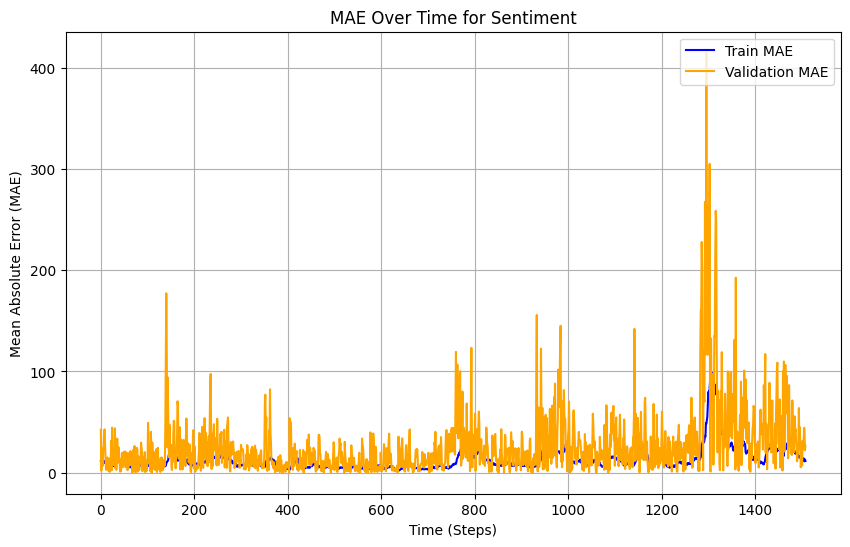

In [16]:
# Results reporting for top_3_indicators and Sentiment
print("Train Results")
print("Indicator\tTrain MAE\tVal MAE")
for indicator in selected_indicators:
    avg_train_mae = np.mean(train_results_sa[indicator]['train_mae'])
    avg_val_mae = np.mean(train_results_sa[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_val_mae:.4f}")

print("\n" + "="*50 + "\n")

print("Validation Results")
print("Indicator\tTrain MAE\tVal MAE")
for indicator in selected_indicators:
    avg_train_mae = np.mean(val_results_sa[indicator]['train_mae'])
    avg_val_mae = np.mean(val_results_sa[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_val_mae:.4f}")

print("\n" + "="*50 + "\n")

print("Test Results")
print("Indicator\tTrain MAE\tTest MAE")
for indicator in selected_indicators:
    avg_train_mae = np.mean(test_results_sa[indicator]['train_mae'])
    avg_test_mae = np.mean(test_results_sa[indicator]['daily_mae'])
    print(f"{indicator:15s}\t{avg_train_mae:.4f}\t\t{avg_test_mae:.4f}")

# Plotting MAE over time (for each indicator and sentiment)
plt.figure(figsize=(10, 6))

# Plot training MAE over time
plt.plot(val_results_sa[indicator]['train_mae'], label="Train MAE", color='blue', linestyle='-')

# Plot validation MAE over time
plt.plot(val_results_sa[indicator]['daily_mae'], label="Validation MAE", color='orange', linestyle='-')

# Adding titles and labels
plt.title(f'MAE Over Time for {indicator}')
plt.xlabel('Time (Steps)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc='upper right')

# Show grid for better readability
plt.grid(True)

# Show the plot
plt.show()


In [34]:
print(train_results_sa)

{'Close_Shifted': {'predictions': [1128.548439282614, 1129.1211486525763, 1139.1508684470434, 1143.0237096150718, 1126.9708564640925, 1129.2542803761314, 1139.6593987116398, 1142.0808872454857, 1133.6523069857865, 1138.3022121994218, 1128.5025557277602, 1135.3031982334142, 1124.6198554532489, 1119.9493712427707, 1121.122641596278, 1118.914247165256, 1114.571841430664, 1111.4005310058592, 1111.4494842529298, 1092.5075022379558, 1095.4171816289993, 1094.6052612304688, 1094.975293782552, 1095.0202616003787, 1093.6951571219308, 1092.2085817512634, 1091.8496546203837, 1092.2263531079177, 1092.0196861049108, 1111.0482692803275, 1107.7543513689138, 1116.0564273797897, 1118.2089057074652, 1118.7093438720701, 1117.7022150675457, 1118.378982775139, 1117.848655324168, 1118.4203542073567, 1129.5335173107328, 1130.5991946265808, 1135.0015454101563, 1129.5814677382964, 1131.8363199565936, 1130.9732869903128, 1133.068822699653, 1133.0740946742467, 1132.8890578939424, 1133.0659296524195, 1136.43556328

# Trading Bot

In [35]:
# initializing agents
# Initial parameters
initial_balance = 200000  # Starting balance in USD
num_agents = 3  # Number of agents

# Define agent strategies
agents = []

# Greedy Buyer Agent
greedy_buyer = {
    'balance': initial_balance,
    'shares_owned': 0,
    'trade_history': [],
    'risk_per_trade': 0.02,  # 2% risk
    'stop_loss_pct': 0.05,   # 5% stop-loss
    'take_profit_pct': 0.05, # 5% take-profit
    'strategy': 'Greedy Buyer'
}
agents.append(greedy_buyer)

# Cautious Investor Agent
cautious_investor = {
    'balance': initial_balance,
    'shares_owned': 0,
    'trade_history': [],
    'risk_per_trade': 0.015,  # 1.5% risk
    'stop_loss_pct': 0.03,    # 3% stop-loss
    'take_profit_pct': 0.04,  # 4% take-profit
    'strategy': 'Cautious Investor'
}
agents.append(cautious_investor)

# Contrarian Trader Agent
contrarian_trader = {
    'balance': initial_balance,
    'shares_owned': 0,
    'trade_history': [],
    'risk_per_trade': 0.02,  # 2% risk
    'stop_loss_pct': 0.06,   # 6% stop-loss
    'take_profit_pct': 0.05, # 5% take-profit
    'strategy': 'Contrarian Trader'
}
agents.append(contrarian_trader)

# Re-initialize cumulative_balances
cumulative_balances = {agent['strategy']: [] for agent in agents}

In [36]:
predicted_prices = test_avg_preds  # Already your model output

# Trading loop for each agent
for i in range(1, len(test_avg_preds)):
    current_price = predicted_prices[i]
    previous_price = predicted_prices[i-1]

        # Print for debugging
    print(f"current_price: {current_price}, previous_price: {previous_price}")

    # Process each agent's trades
    for agent in agents:
        balance = agent['balance']
        shares_owned = agent['shares_owned']
        risk_per_trade = agent['risk_per_trade']
        stop_loss_pct = agent['stop_loss_pct']
        take_profit_pct = agent['take_profit_pct']
        trade_history = agent['trade_history']
        strategy = agent['strategy']

        # Track cumulative balance for plotting
        cumulative_balance = balance + (shares_owned * current_price)  # Portfolio value

        # Initialize cumulative_balances dictionary if it doesn't exist
        if strategy not in cumulative_balances:
            cumulative_balances[strategy] = []

        # Add cumulative balance to the list for this agent
        cumulative_balances[strategy].append(cumulative_balance)


        # Determine the amount of capital to risk per trade for this agent
        risk_capital = balance * risk_per_trade

        # --- Strategy: Greedy Buyer ---
        if strategy == 'Greedy Buyer':
            # Buy when price is rising
            if current_price > previous_price and balance >= current_price:
                shares_to_buy = risk_capital // current_price
                if shares_to_buy == 0:
                    continue

                balance -= shares_to_buy * current_price
                shares_owned += shares_to_buy

                # Calculate stop-loss and take-profit levels
                stop_loss = current_price * (1 - stop_loss_pct)
                take_profit = current_price * (1 + take_profit_pct)

                trade_history.append(f"Greedy Buyer BUY {shares_to_buy} at {current_price}, Stop-Loss: {stop_loss}, Take-Profit: {take_profit}")

            # Sell if price drops (quick profit-taking)
            elif current_price < previous_price and shares_owned > 0:
                balance += shares_owned * current_price
                trade_history.append(f"Greedy Buyer SELL {shares_owned} at {current_price}")
                shares_owned = 0

        # --- Strategy: Cautious Investor ---
        if strategy == 'Cautious Investor':
            # Only buy if price has increased for 3 consecutive days
            if current_price > previous_price and (avg_preds[i-1] > avg_preds[i-2]):
                if balance >= current_price:
                    shares_to_buy = risk_capital // current_price
                    if shares_to_buy == 0:
                        continue

                    balance -= shares_to_buy * current_price
                    shares_owned += shares_to_buy

                    # Calculate stop-loss and take-profit levels
                    stop_loss = current_price * (1 - stop_loss_pct)
                    take_profit = current_price * (1 + take_profit_pct)

                    trade_history.append(f"Cautious Investor BUY {shares_to_buy} at {current_price}, Stop-Loss: {stop_loss}, Take-Profit: {take_profit}")

            # Sell if price decreases (cutting losses early)
            elif current_price < previous_price and shares_owned > 0:
                balance += shares_owned * current_price
                trade_history.append(f"Cautious Investor SELL {shares_owned} at {current_price}")
                shares_owned = 0

        # --- Strategy: Contrarian Trader ---
        if strategy == 'Contrarian Trader':
            # Buy when price is falling (expecting reversal)
            if current_price < previous_price and balance >= current_price:
                shares_to_buy = risk_capital // current_price
                if shares_to_buy == 0:
                    continue

                balance -= shares_to_buy * current_price
                shares_owned += shares_to_buy

                # Calculate stop-loss and take-profit levels
                stop_loss = current_price * (1 - stop_loss_pct)
                take_profit = current_price * (1 + take_profit_pct)

                trade_history.append(f"Contrarian Trader BUY {shares_to_buy} at {current_price}, Stop-Loss: {stop_loss}, Take-Profit: {take_profit}")

            # Sell when price is rising (expecting correction)
            elif current_price > previous_price and shares_owned > 0:
                balance += shares_owned * current_price
                trade_history.append(f"Contrarian Trader SELL {shares_owned} at {current_price}")
                shares_owned = 0

        # Update agent's information
        agent['balance'] = balance
        agent['shares_owned'] = shares_owned

# After the loop, check the final balance (after selling all shares) for each agent
for agent_id, agent in enumerate(agents):
    final_balance = agent['balance'] + (agent['shares_owned'] * full_df['Close'].iloc[-1])  # Add the value of remaining shares
    print(f"Agent {agent_id+1} ({agent['strategy']}) Final Balance: {final_balance}")
    print(f"Agent {agent_id+1} Trade History:", agent['trade_history'])

current_price: 3797.984422002354, previous_price: 3801.1781586805123
current_price: 3838.2958144802515, previous_price: 3797.984422002354
current_price: 3844.928065369434, previous_price: 3838.2958144802515
current_price: 3868.8006143965385, previous_price: 3844.928065369434
current_price: 3896.8475311279294, previous_price: 3868.8006143965385
current_price: 3903.2111338249088, previous_price: 3896.8475311279294
current_price: 3906.567311604818, previous_price: 3903.2111338249088
current_price: 3906.943834320993, previous_price: 3906.567311604818
current_price: 3926.23596476237, previous_price: 3906.943834320993
current_price: 3923.340823189871, previous_price: 3926.23596476237
current_price: 3916.627668597509, previous_price: 3923.340823189871
current_price: 3915.1211431888487, previous_price: 3916.627668597509
current_price: 3896.723244501419, previous_price: 3915.1211431888487
current_price: 3889.40962753948, previous_price: 3896.723244501419
current_price: 3919.257445859923, previo

In [ ]:
# Plotting the cumulative performance of each agent
plt.figure(figsize=(12, 6))

# Ensure that the number of time steps matches the length of cumulative_balances
time_steps = range(1, len(cumulative_balances[next(iter(cumulative_balances))]) + 1)

# Plot the cumulative balance for each agent's strategy
for agent in agents:
    strategy = agent['strategy']
    plt.plot(time_steps, cumulative_balances[strategy], label=strategy)

plt.title('Performance Comparison of Trading Agents')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Portfolio Value (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
